# **SETTING THE ENVIRONMENT**

In [ ]:
#environment & libraries
!apt-get install tshark #install tshark
!pip install pyshark #install python library for tshark

import os
import nest_asyncio
import pyshark
import pandas as pd
import numpy as np

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libc-ares2 libcap2-bin liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpam-cap
  libpcap0.8 libsbc1 libsmi2ldbl libspandsp2 libwireshark-data libwireshark11
  libwiretap8 libwscodecs2 libwsutil9 wireshark-common
Suggested packages:
  mmdb-bin snmp-mibs-downloader wireshark-doc
The following NEW packages will be installed:
  libc-ares2 libcap2-bin liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpam-cap
  libpcap0.8 libsbc1 libsmi2ldbl libspandsp2 libwireshark-data libwireshark11
  libwiretap8 libwscodecs2 libwsutil9 tshark wireshark-common
0 upgraded, 17 newly installed, 0 to remove and 19 not upgraded.
Need to get 16.5 MB of archives.
After this operation, 95.6 MB of additional disk space will be used.
Get:1 

# **CHECK: PROBE REQUESTS ARE ALL VALID**

The objective of this phase is to check that all the packets included in the pcap file are valid. To do so, it is necessary to check a few relevant data fields such as source address, RSSI, SSID and the timestamp.
The reader can change the name of the variable **captureName**, and with it all the following code will revolve around the wanted packet capture

In [ ]:
nest_asyncio.apply() 
captureName = "6_Probes_Inactive+Plane.pcap"
capture = pyshark.FileCapture(captureName)

count = 0
successful_packets = 0
for packet in capture :
  #some packets might be malformed, so not all information is available in a packet; we need a try-except block
  success = False
  count = count + 1 #counting processed packets

  try:
    timestamp = packet.sniff_timestamp
    wlan_layers = packet.get_multiple_layers("wlan") 
    sa = wlan_layers[0].SA
    ssid = wlan_layers[1].SSID
    rssi = packet.wlan_radio.signal_dbm
    success = True
  except:
    success = False
  
  if (success) : #if the packet was a good one, we append information
    successful_packets = successful_packets + 1 #to count successful packets

  
print("Read packets: ", count)
print("Successfully processed packets: ", successful_packets)

Read packets:  425
Successfully processed packets:  425


# **FILTERING PROBE REQUESTS and CHECKING RANDOMICITY**

In this phase we only select those packets that come from sources that have recorded RSSI greater than -50. As the experiment could not be carried out in an isolated room, it is necessary to filter out any probe request coming from different devices from that used in the project, and due to the nature of the experiment it is impossible to filter based on the MAC source address.
The selected source addresses will be, therefore, called "valid" source addresses.

In [ ]:
valid_SA = [] #list for the "valid" addresses
total_SA = [] #list for all the addresses

for packet in capture :
  if int(packet.wlan_radio.signal_dbm) > -50 and not(packet.wlan.sa in valid_SA) :
    valid_SA.append(packet.wlan.sa)
  if not (packet.wlan.sa in total_SA) :
    total_SA.append(packet.wlan.sa)

print("total source addresses: " + str(len(total_SA)))
print("valid source addresses: " + str(len(valid_SA)))


total source addresses: 189
valid source addresses: 33


This subsequent check allows to check that every MAC address selected in valid_SA is indeed a randomized MAC address.

In [ ]:
def is_random_mac(sa): #function to check if a MAC address is random or real
  first_octet = '0x' + sa[0:2] #first byte of the MAC address in hexadecimal value
  first_octet = int(format(int(first_octet,16), '08b'), 2) #from hexa to binary 8 bit
  #now we apply a mask: bitwise octet AND 00000010; this will give us the result 00000000 = 0 FAKE or 00000010 = 2 > 1 = REAL
  mask = int(format(2, '08b'), 2)
  if(mask & first_octet > 0) :
    return True
  else:
    return False

RANDOM_MAC = []
for sa in valid_SA :
  RANDOM_MAC.append(is_random_mac(sa))

random_addr = 0
true_addr = 0
for sa in valid_SA:
  if is_random_mac(sa):
    random_addr += 1
  else :
    true_addr += 1

print('There were ' + str(true_addr) + ' real MAC addresses')

There were 0 real MAC addresses


Lastly, in this phase we create a new pcap file by selecting only packets whose source addresses are in valid_SA, and pruning all the others. This operation can be effectively carried out by taking advantage of the display_filter parameter of FileCapture: such parameter behaves exactly as a display filter in wireshark, so it is enough to feed it an adequate string filter.
The string filter is created by the filter_generator method, which creates a whitelist of allowed source addresses from the valid_SA list.
To check that this step was successful, we check that the number of packets in the validCapture is equal to the packets whose source address is in valid_SA.

In [ ]:
def filter_generator(SA):
  filter = ""
  for address in SA:
    filter = filter + "wlan.sa == " + str(address)
    if not(address == SA[len(SA) -1]) :
      filter = filter + " or "
  print(filter)
  return filter

outputFile = "Filtered_" + captureName
validCapture = pyshark.FileCapture(captureName, display_filter=filter_generator(valid_SA), output_file=outputFile)

valid = 0
for packet in validCapture :
    valid += 1

filterChecker = 0
for packet in capture :
  if packet.wlan.sa in valid_SA :
    filterChecker += 1

print("Was the filter effectful? " + str(filterChecker == valid))
print("Selected packets: " + str(valid))

wlan.sa == da:a1:19:ee:26:96 or wlan.sa == da:a1:19:93:35:3b or wlan.sa == da:a1:19:06:3e:d0 or wlan.sa == da:a1:19:5a:00:6d or wlan.sa == da:a1:19:63:57:aa or wlan.sa == da:a1:19:e2:db:ab or wlan.sa == da:a1:19:c6:c9:19 or wlan.sa == da:a1:19:65:c4:0e or wlan.sa == da:a1:19:f8:4a:1f or wlan.sa == da:a1:19:c3:6b:25 or wlan.sa == da:a1:19:68:75:a8 or wlan.sa == da:a1:19:b4:4d:29 or wlan.sa == da:a1:19:71:25:fb or wlan.sa == da:a1:19:85:f0:8f or wlan.sa == da:a1:19:4f:d3:4f or wlan.sa == da:a1:19:c7:00:61 or wlan.sa == da:a1:19:86:0c:89 or wlan.sa == da:a1:19:70:9e:c7 or wlan.sa == da:a1:19:ff:67:1e or wlan.sa == da:a1:19:2b:2c:cf or wlan.sa == da:a1:19:be:47:89 or wlan.sa == da:a1:19:84:87:aa or wlan.sa == da:a1:19:17:77:bf or wlan.sa == da:a1:19:7a:e0:d4 or wlan.sa == da:a1:19:85:81:61 or wlan.sa == da:a1:19:e6:90:1f or wlan.sa == da:a1:19:ca:8a:8c or wlan.sa == da:a1:19:19:36:7d or wlan.sa == da:a1:19:0b:be:bb or wlan.sa == da:a1:19:27:cd:7f or wlan.sa == da:a1:19:98:e9:3d or wlan.sa 

# **AVERAGE RSSI and IAT**

This section aims at producing and showing some additional data that can allow to better analyse the captures at hand. First probes are displayed by grouping them by Source Address, SA; 

In [ ]:
revTIMESTAMP = [] #list for timestamps
revSA = [] #list for source addresses
revRSSI = [] #list for signal strenght

for packet in validCapture :
  wlan_layers = packet.get_multiple_layers("wlan")
  revTIMESTAMP.append(packet.sniff_timestamp)
  revSA.append(wlan_layers[0].SA)
  revRSSI.append(packet.wlan_radio.signal_dbm)

#create DATAFRAME -> a table created from the lists we extracted
df_cap = pd.DataFrame(list(zip(revTIMESTAMP, revSA, revRSSI)), columns = ['TA', 'SA', 'RSSI'])

#now we can group all probe requests from the same source address in a single variable, through the "group by"
df_sa = df_cap.groupby(['SA']) #we group by Source address
display(df_sa)

for sa, probes in df_sa:
  print(sa)
  display(probes)

df_sa = df_cap.groupby(['SA']) #we group by Source


da:a1:19:06:3e:d0


,TA,SA,RSSI
3,1659104441.544477000,da:a1:19:06:3e:d0,-44


da:a1:19:0b:be:bb


,TA,SA,RSSI
37,1659105226.174129000,da:a1:19:0b:be:bb,-29


da:a1:19:17:77:bf


,TA,SA,RSSI
29,1659105035.803856000,da:a1:19:17:77:bf,-26
30,1659105035.828935000,da:a1:19:17:77:bf,-28


da:a1:19:19:36:7d


,TA,SA,RSSI
36,1659105162.873957000,da:a1:19:19:36:7d,-45


da:a1:19:27:cd:7f


,TA,SA,RSSI
38,1659105226.322079000,da:a1:19:27:cd:7f,-45


da:a1:19:2b:2c:cf


,TA,SA,RSSI
25,1659104909.083344000,da:a1:19:2b:2c:cf,-44


da:a1:19:4f:d3:4f


,TA,SA,RSSI
18,1659104718.745482000,da:a1:19:4f:d3:4f,-44


da:a1:19:5a:00:6d


,TA,SA,RSSI
4,1659104464.852549000,da:a1:19:5a:00:6d,-17


da:a1:19:63:57:aa


,TA,SA,RSSI
5,1659104465.000970000,da:a1:19:63:57:aa,-44


da:a1:19:65:c4:0e


,TA,SA,RSSI
8,1659104528.457360000,da:a1:19:65:c4:0e,-45


da:a1:19:68:75:a8


,TA,SA,RSSI
12,1659104655.128825000,da:a1:19:68:75:a8,-14
13,1659104655.153966000,da:a1:19:68:75:a8,-17


da:a1:19:70:9e:c7


,TA,SA,RSSI
21,1659104845.463992000,da:a1:19:70:9e:c7,-26
22,1659104845.489097000,da:a1:19:70:9e:c7,-28


da:a1:19:71:25:fb


,TA,SA,RSSI
15,1659104718.572691000,da:a1:19:71:25:fb,-95
16,1659104718.597625000,da:a1:19:71:25:fb,-17


da:a1:19:75:45:44


,TA,SA,RSSI
41,1659105289.767650000,da:a1:19:75:45:44,-44


da:a1:19:7a:e0:d4


,TA,SA,RSSI
31,1659105035.977348000,da:a1:19:7a:e0:d4,-45


da:a1:19:84:87:aa


,TA,SA,RSSI
28,1659104972.530467000,da:a1:19:84:87:aa,-45


da:a1:19:85:81:61


,TA,SA,RSSI
32,1659105099.253690000,da:a1:19:85:81:61,-27


da:a1:19:85:f0:8f


,TA,SA,RSSI
17,1659104718.659483000,da:a1:19:85:f0:8f,-16


da:a1:19:86:0c:89


,TA,SA,RSSI
20,1659104782.192693000,da:a1:19:86:0c:89,-44


da:a1:19:93:35:3b


,TA,SA,RSSI
1,1659104441.371383000,da:a1:19:93:35:3b,-14
2,1659104441.396348000,da:a1:19:93:35:3b,-18


da:a1:19:98:e9:3d


,TA,SA,RSSI
39,1659105289.594291000,da:a1:19:98:e9:3d,-23
40,1659105289.619433000,da:a1:19:98:e9:3d,-26


da:a1:19:a4:60:89


,TA,SA,RSSI
42,1659105289.853158000,da:a1:19:a4:60:89,-49


da:a1:19:b4:4d:29


,TA,SA,RSSI
14,1659104655.302995000,da:a1:19:b4:4d:29,-44


da:a1:19:be:47:89


,TA,SA,RSSI
26,1659104972.357016000,da:a1:19:be:47:89,-25
27,1659104972.382081000,da:a1:19:be:47:89,-29


da:a1:19:c3:6b:25


,TA,SA,RSSI
11,1659104591.904906000,da:a1:19:c3:6b:25,-44


da:a1:19:c6:c9:19


,TA,SA,RSSI
7,1659104528.370866000,da:a1:19:c6:c9:19,-15


da:a1:19:c7:00:61


,TA,SA,RSSI
19,1659104782.019307000,da:a1:19:c7:00:61,-14


da:a1:19:ca:8a:8c


,TA,SA,RSSI
34,1659105162.700220000,da:a1:19:ca:8a:8c,-26
35,1659105162.725406000,da:a1:19:ca:8a:8c,-28


da:a1:19:e2:db:ab


,TA,SA,RSSI
6,1659104528.282483000,da:a1:19:e2:db:ab,-14


da:a1:19:e6:90:1f


,TA,SA,RSSI
33,1659105099.426486000,da:a1:19:e6:90:1f,-45


da:a1:19:ee:26:96


,TA,SA,RSSI
0,1659104418.196588000,da:a1:19:ee:26:96,-25


da:a1:19:f8:4a:1f


,TA,SA,RSSI
9,1659104591.734880000,da:a1:19:f8:4a:1f,-14
10,1659104591.759941000,da:a1:19:f8:4a:1f,-17


da:a1:19:ff:67:1e


,TA,SA,RSSI
23,1659104908.910168000,da:a1:19:ff:67:1e,-26
24,1659104908.935454000,da:a1:19:ff:67:1e,-28


then mean RSSI and IAT are produced for each source address. The IAT, in particular, is the **interval arrival time** and it expresses the elapsed time between two frame arrivals from the same source address. Notice that if a source address sends only one packet, the IAT is null and it is thus not recorded.

This section was similarly done in class, but the code showed here has been modified to better adapt to the situation at hand. As a matter of fact, it was observed that under certain circumstances the analysed device randomizes the MAC source address so much that only 1 or 2 packets are sent before randomizing again; for this very reason in the follwing code we will consider all packets from the validCapture rather than just packets from sources that have recorded more than 10 probes.

In [ ]:
MEAN_RSSI = []
MEAN_IAT = []

for sa, probes in df_sa:
  rssi = probes['RSSI'].astype(float).mean() #taking all RSSIs and working out the mean 
  iat = probes['TA'].astype(float).diff(1).mean() #this takes the difference one by one, thus creating a vector, and then makes the mean
  MEAN_RSSI.append(rssi)
  MEAN_IAT.append(iat)

here additional data is calculated

*   the average RSSI and IAT
*   the Relative Percentage Distance, RPD, of each value, so that it is possible to put under perspective how much they vary



In [ ]:
counter = 0
notNaNcounter = 0

import math
from math import inf as inf

avgRSSI = 0
maxRSSI = -inf
minRSSI = inf

avgIAT = 0
maxIAT = -inf
minIAT = inf


for x in range(0, len(MEAN_RSSI)) :
  avgRSSI += MEAN_RSSI[x]

  if MEAN_RSSI[x] > maxRSSI :
    maxRSSI = MEAN_RSSI[x]
  elif MEAN_RSSI[x] < minRSSI :
    minRSSI = MEAN_RSSI[x]

  if not(math.isnan(MEAN_IAT[x])) :
    notNaNcounter += 1
    avgIAT += MEAN_IAT[x]

    if MEAN_IAT[x] > maxIAT :
      maxIAT = MEAN_IAT[x]
    elif MEAN_IAT[x] < minIAT :
      minIAT = MEAN_IAT[x]

  counter += 1

avgRSSI = avgRSSI/counter
avgIAT = avgIAT/notNaNcounter

#RPD : Relative Percentage Difference
RDP_RSSI = -100*(maxRSSI - minRSSI)/avgRSSI
RDP_IAT = 100*(maxIAT - minIAT)/avgIAT

print("Average RSSI: " + str(round(avgRSSI,4)) + ";\t\tRSSI RDP: " + str(round(RDP_RSSI,4)))
print("Max RSSI: " + str(round(maxRSSI,4)) + ";\t\tMin RSSI: " + str(round(minRSSI,4)))
print("")
print("Average IAT: " + str(round(avgIAT,4)) + ";\t\tIAT RDP: " + str(round(RDP_IAT,4)))
print("Max IAT: " + str(round(maxIAT,4)) + ";\t\tMin IAT: " + str(round(minIAT,4)))


Average RSSI: -51.8288;		RSSI RDP: 6.4332
Max RSSI: -50.4783;		Min RSSI: -53.8125

Average IAT: 0.0124;		IAT RDP: 21.5667
Max IAT: 0.0135;		Min IAT: 0.0109


lastly, and truly lastly, histograms for the mean RSSI and IAT values are plotted.

Text(0, 0.5, 'Frequency')

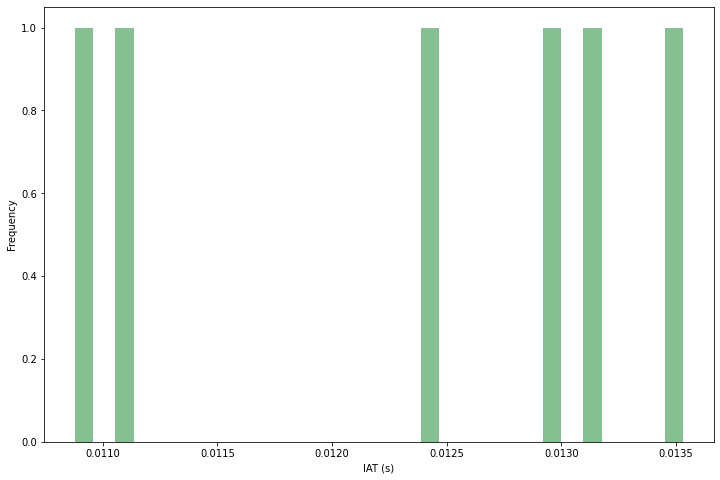

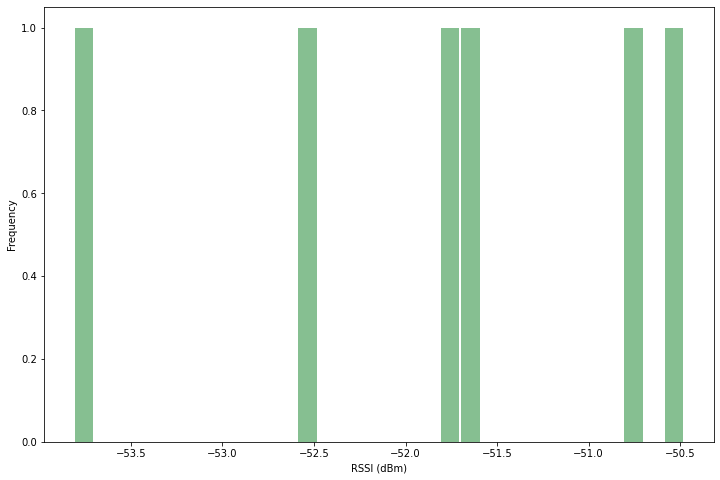

In [ ]:
import matplotlib.pyplot as plt

#IAT hist
fig = plt.figure(figsize = (12,8))
plt.hist(MEAN_IAT, 30, density = False, color='#86bf91', rwidth=0.9)
plt.grid(visible = False)
plt.xlabel('IAT (s)')
plt.ylabel('Frequency')


#RSSI hist
fig = plt.figure(figsize = (12,8))
plt.hist(MEAN_RSSI, 30, density = False, color='#86bf91', rwidth=0.9)
plt.grid(visible = False)
plt.xlabel('RSSI (dBm)')
plt.ylabel('Frequency')